# Sales Forecasting for Daily Sales on Time-series Data

In [15]:
#Importing Libraries, setting up plot inlines
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 24, 8

import plotly
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
#----------------------------------------------------------------------------------------------------------

## Product Visualizations

In [16]:
#Loading the dataset
FullData=pd.read_csv(r'FinalDataToAnalyze.csv', encoding='latin-1')
dataset=FullData.where(FullData.SalesTerritoryGroup=='Europe')
dataset=dataset.dropna()
VisData=dataset.groupby(dataset.ProductCategoryKey).sum()
# print(VisData)
values = [VisData.OrderQuantity[x] for x in VisData.index]
labels = ['Product '+ str(x) for x in VisData.index]

trace = go.Pie(labels=labels, values=values)
plotly.offline.iplot([trace], filename='basic_pie_chart')
#----------------------------------------------------------------------------------------------------------

## Data Gathering and Data Preparation

In [17]:
#Taking only CATEGORY 4 products(as highest in number)
dataset=dataset.where(dataset.ProductSubcategoryKey<=37)
dataset=dataset.where(dataset.ProductSubcategoryKey>=26)
dataset=dataset.dropna()
#----------------------------------------------------------------------------------------------------------

#Creating Dummies of Gender Category(Converting Categorical Data into Numerical Data)
datasetdummies = pd.get_dummies(dataset['Gender'])
dataset=dataset.join(datasetdummies)
#----------------------------------------------------------------------------------------------------------

#Making significance of Calendar-Year to be more logical(Illogical Numerical data into logical)
dataset.CalendarYear=2015-dataset.CalendarYear
#----------------------------------------------------------------------------------------------------------

#Dropping non-required features(Feature Selection)
NotToDrop=['FullDateAlternateKey', 'SalesAmount', 'M', 'YearlyIncome', 'ProductSubcategoryKey',
           'MonthNumberOfYear', 'DayNumberOfMonth', 'DayNumberOfWeek','DiscountPct']
drop_elements = np.array(dataset.columns).tolist()
for x in range(0,len(NotToDrop)):
    drop_elements.remove(NotToDrop[x])

dataset = dataset.drop(drop_elements, axis = 1)
#----------------------------------------------------------------------------------------------------------

#Setting TIME as INDEX
dataset['FullDateAlternateKey'] = pd.to_datetime(dataset['FullDateAlternateKey'])
dataset = dataset.set_index('FullDateAlternateKey')
#----------------------------------------------------------------------------------------------------------

#Grouping Data for unique days
dataset = dataset.groupby(dataset.index).sum()
#----------------------------------------------------------------------------------------------------------

#Transforming Data(Making the data consistent)
#dataset['SalesAmount'] = dataset.groupby('MonthNumberOfYear')['SalesAmount'].transform(lambda x:x+np.average(x))
dataset.SalesAmount=np.log(dataset.SalesAmount)
dataset.YearlyIncome=np.log(dataset.YearlyIncome)
dataset.DiscountPct=dataset.DiscountPct+100
#----------------------------------------------------------------------------------------------------------

## Cheking inter-dependence of features using Pearson Correlation

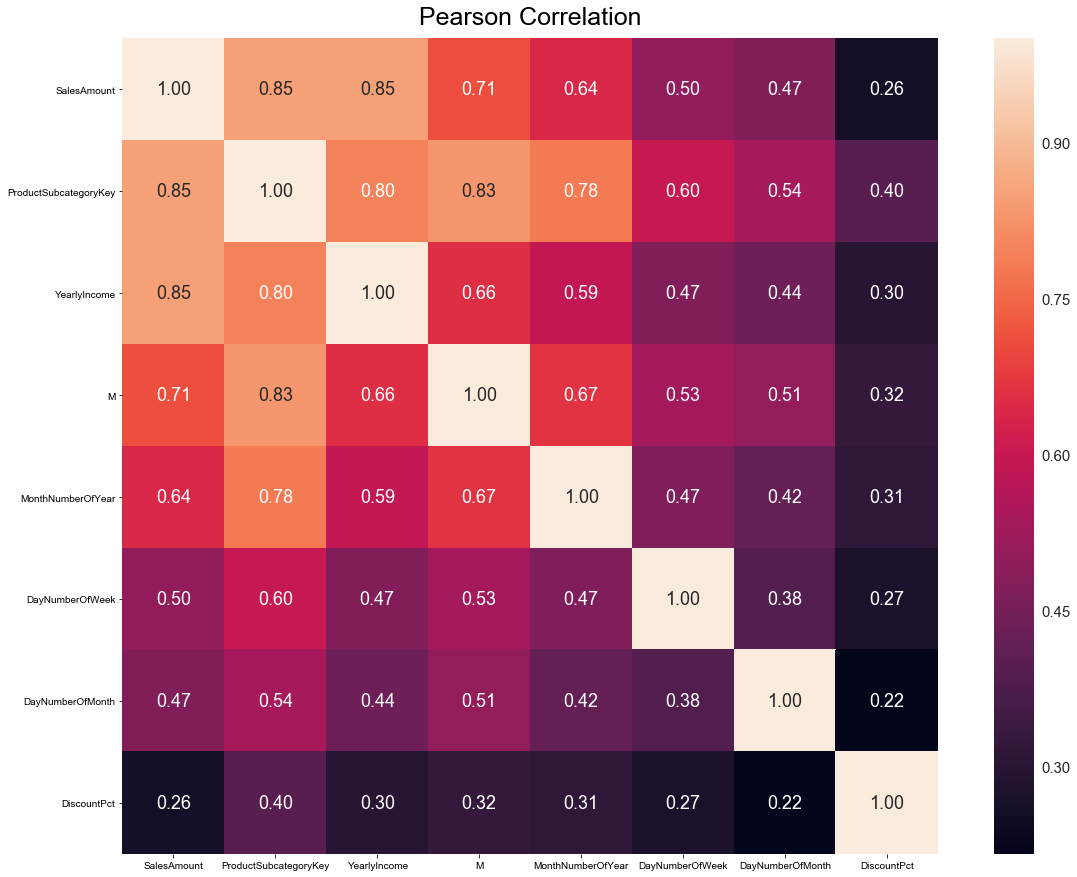

In [18]:
#PEARSON CORRELATION
correlation = dataset.corr(method='pearson')
columns = correlation.nlargest(20, 'SalesAmount').index
correlation_map = np.corrcoef(dataset[columns].values.T)
plt.figure(figsize=(20,15))
plt.title('Pearson Correlation', y=1.01, size=25)

sns.set(font_scale=1.5)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)
plt.show()
#----------------------------------------------------------------------------------------------------------

## Data split for Training

In [19]:
#Initializing with Data Split for final model(Gradient Boosting or others)
X = dataset[columns]
Y = X['SalesAmount'].values
X = X.drop('SalesAmount', axis = 1).values
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=17)
#----------------------------------------------------------------------------------------------------------

## Checking what model would be more efficient?, and Evaluating Model

In [20]:
#Importing libraries for Checking which Models to use
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
#----------------------------------------------------------------------------------------------------------

#To DECIDE what MODEL to use
pipelines = []
pipelines.append(('ScaledLinReg', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLassoReg', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledElasticNetRegression', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', StandardScaler()),('XGB', XGBRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
#----------------------------------------------------------------------------------------------------------

ScaledLinReg: -0.077570 (0.049186)
ScaledLassoReg: -0.363987 (0.183024)
ScaledElasticNetRegression: -0.354370 (0.186390)
ScaledKNN: -0.086229 (0.077716)
ScaledCART: -0.119068 (0.061079)
ScaledGBM: -0.079780 (0.059939)
ScaledXGB: -0.078507 (0.057484)


In [21]:
#Using Model acc to above values, finding n_estimator number
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
rescaled_X_train = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,200,300,400]))
model = XGBRegressor(random_state=21)
kfold = KFold(n_splits=10, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaled_X_train, Y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#----------------------------------------------------------------------------------------------------------

-0.079437 (0.062299) with: {'n_estimators': 50}
-0.078220 (0.058179) with: {'n_estimators': 100}
-0.078423 (0.054004) with: {'n_estimators': 200}
-0.079187 (0.053168) with: {'n_estimators': 300}
-0.079894 (0.052569) with: {'n_estimators': 400}
Best: -0.078220 using {'n_estimators': 100}


In [22]:
#Checking MSE - Mean Squared Error
from sklearn.metrics import mean_squared_error

model = XGBRegressor(random_state=21, n_estimators=100)
model.fit(rescaled_X_train, Y_train)

# transform the validation dataset
rescaled_X_test = scaler.transform(X_test)
predictions = model.predict(rescaled_X_test)
print (mean_squared_error(Y_test, predictions))
#----------------------------------------------------------------------------------------------------------

0.05683586646865181


In [23]:
#Converting PREDICTED DATA(Scaled) into ACTUAL Data(Unscaled) form
compare = pd.DataFrame({'Prediction': predictions, 'Test Data' : Y_test})
compare.head(3)

actual_y_test = np.exp(Y_test)
actual_predicted = np.exp(predictions)
diff = abs(actual_y_test - actual_predicted)

compare_actual = pd.DataFrame({'Test Data': actual_y_test, 'Predicted Price' : actual_predicted, 'Difference' : diff})
compare_actual = compare_actual.astype(int)
compare_actual.head()
#----------------------------------------------------------------------------------------------------------


,Difference,Predicted Price,Test Data
0,262,314,576
1,49,265,215
2,84,300,215
3,47,626,674
4,21,336,315


In [24]:
#Finding ACCURACY of Model
from sklearn.metrics import r2_score

accuracy = r2_score(actual_y_test, actual_predicted)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#----------------------------------------------------------------------------------------------------------

Accuracy: 82.63%


## How our test data looks with its prediction?

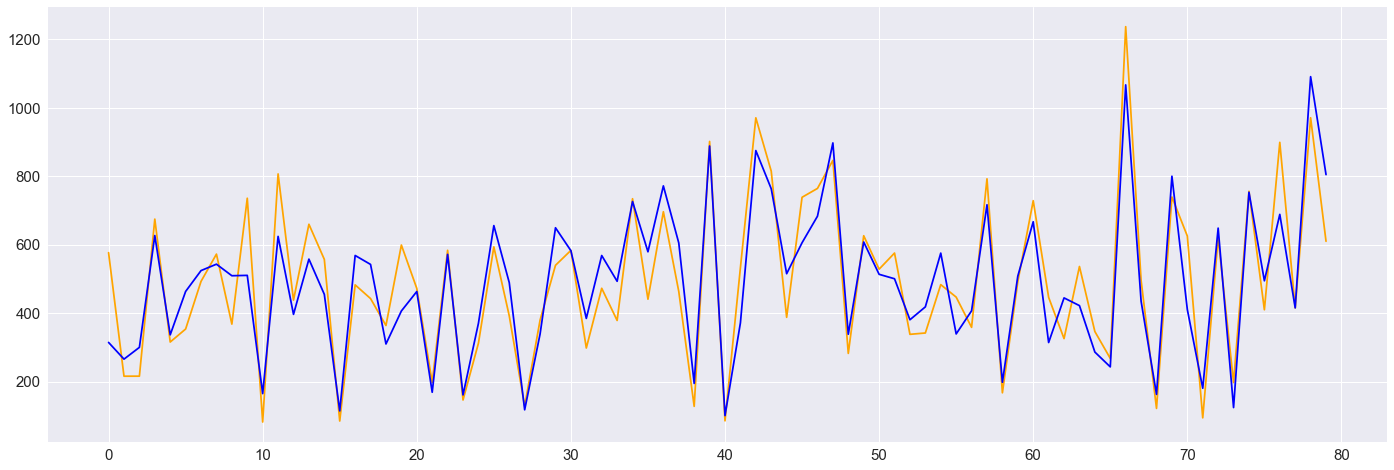

In [25]:
#Plotting test vs prediction
plt.plot(actual_y_test, color='orange')
plt.plot(actual_predicted, color='blue')
plt.show()
#----------------------------------------------------------------------------------------------------------